In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
data = np.load('/u/scr/ethanchi/embeddings/temporal/representations.npy')
print(data.shape)

(65536, 30, 768)


In [4]:
labels = pd.read_csv('/u/scr/ethanchi/embeddings/temporal/sentences.txt', sep="\t")

In [5]:
cut_data = data[(labels['verb1_char'] == 1) & (labels['verb2_char'] == 1)]
both_past = labels[(labels['verb1_char'] == 1) & (labels['verb2_char'] == 1)]
print(both_past.shape)


(16384, 11)


In [6]:
# we train a direction vector
verb1_indices = both_past['verb1'].astype('int32').values
print(verb1_indices)
verb2_indices = both_past['verb2'].astype('int32').values

directions = np.where(both_past['connector_char'] == 'past', 1, -1)
print(directions)

[2 2 2 ... 2 2 2]
[-1 -1 -1 ...  1  1  1]


In [7]:
print(both_past.shape)
verb1_embeddings = cut_data[np.arange(both_past.shape[0]), list(verb1_indices), :]
verb2_embeddings = cut_data[np.arange(both_past.shape[0]), list(verb2_indices), :]

print(verb1_embeddings.shape, verb2_embeddings.shape)

(16384, 11)
(16384, 768) (16384, 768)


In [23]:
data_raw = (verb1_embeddings - verb2_embeddings) * directions[:, np.newaxis]
indices = np.arange(data_raw.shape[0])
np.random.shuffle(indices)

sep = int(indices.shape[0] * .9)

train_set_raw = data_raw[:sep]
test_set_raw = data_raw[sep:]

train_labels = both_past[:sep]
test_labels = both_past[sep:]

# train_set_raw = 
# test_set_raw = 

train_set = train_set_raw / np.linalg.norm(train_set_raw, axis=1, keepdims=True)
test_set = test_set_raw / np.linalg.norm(test_set_raw, axis=1, keepdims=True)

In [9]:
input_size = data.shape[-1]

class DirectionProbe(nn.Module):
    def __init__(self, inputSize):
        super(DirectionProbe, self).__init__()
        self.inputSize = inputSize
        self.u = nn.Parameter(data = torch.zeros(self.inputSize))
        nn.init.uniform_(self.u, -0.05, 0.05)
    def forward(self, batch):
        return torch.mean(batch @ (self.u / torch.norm(self.u)))

train_inputs = torch.Tensor(train_set)
test_inputs = torch.Tensor(test_set)
model = DirectionProbe(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

NUM_EPOCHS = 2000

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    output = model(train_inputs)
    error = 1 - output
    error.backward()
    optimizer.step()
    if epoch % 100 == 0:
        test_output = model(test_inputs)
        print("Epoch {}, train score {}, test score {}".format(epoch, output, test_output))


Epoch 0, train score -5.7520668633515015e-05, test score 0.0002788833517115563
Epoch 100, train score 0.012569215148687363, test score 0.012704465538263321
Epoch 200, train score 0.024264929816126823, test score 0.024305295199155807
Epoch 300, train score 0.03355085104703903, test score 0.03352995961904526
Epoch 400, train score 0.03991355001926422, test score 0.0398222841322422
Epoch 500, train score 0.043752945959568024, test score 0.04355034977197647
Epoch 600, train score 0.0457925871014595, test score 0.045484308153390884
Epoch 700, train score 0.04674059525132179, test score 0.046358637511730194
Epoch 800, train score 0.04713078960776329, test score 0.046707600355148315
Epoch 900, train score 0.04727807268500328, test score 0.0468357652425766
Epoch 1000, train score 0.04733134061098099, test score 0.046882081776857376
Epoch 1100, train score 0.04735029488801956, test score 0.04689951241016388
Epoch 1200, train score 0.04735695198178291, test score 0.04690644517540932
Epoch 1300, 

In [18]:
EPSILON = 1e-6
direction_vector = model.u.cpu().detach().numpy()
direction_vector /= np.linalg.norm(direction_vector)
numSuccessful = len(np.where(np.linalg.norm(train_set_raw + EPSILON * direction_vector, axis=1) > np.linalg.norm(train_set_raw, axis=1))[0])
print(numSuccessful / train_set_raw.shape[0])

0.8101729399796541


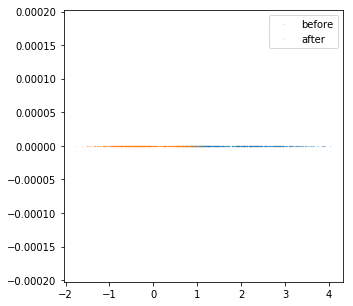

In [15]:
plt.figure(figsize=(5, 5))

test_directions = directions[sep:]

before = test_set_raw[test_directions == -1] @ direction_vector
after = test_set_raw[test_directions == 1] @ direction_vector

plt.scatter(before, np.zeros(before.shape[0]), label="before", s=0.01)
plt.scatter(after, np.zeros(after.shape[0]), label="after", s=0.01)

plt.legend()

plt.show()

after 1.0
before 0.8151041666666666
earlier than 0.029017857142857144
later than 1.0
(1639, 11)


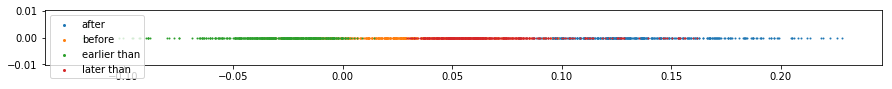

In [30]:
plt.figure(figsize=(15, 1))

for word in ('after', 'before', 'earlier than', 'later than'):
  arr = test_set[np.vectorize(lambda x: word in x)(test_labels['sentence'])] @ direction_vector
  plt.scatter(arr, np.zeros(arr.shape[0]), label=word, s=1)
  print(word, len(np.where(np.linalg.norm(test_set[np.vectorize(lambda x: word in x)(test_labels['sentence'])] + EPSILON * direction_vector, axis=1) > np.linalg.norm(test_set[np.vectorize(lambda x: word in x)(test_labels['sentence'])], axis=1))[0]) /
       len(test_set[np.vectorize(lambda x: word in x)(test_labels['sentence'])]))


print(test_labels.shape)

plt.legend(markerscale=2)

plt.show()